In [122]:
'''importa as bibliotecas necessárias'''
import matplotlib.pyplot as plt  # importar a bilioteca pyplot para fazer gráficos
import numpy as np   # importar a biblioteca Numpy para lidar com matrizes
import time          # importar a bilioteca para funções temporais
import pandas as pd   # importa bilioteca pandas para  lidar com processamento de dados
import os            # biblioteca para lidar com diretórios
import scipy.io #pacote para carregar dados do matlab
from scipy.optimize import curve_fit # pacote para ajuste de curvas
from scipy import optimize
%matplotlib inline   

In [19]:
folder_path=os.getcwd()
print('pasta atual:',folder_path)        
#O ARQUIVO DE DADOS DEVE ESTAR NESTA PASTA:
file_name = 'exp_1a_dados_22_33_42.dat'
file=os.path.join(folder_path,file_name)
dados_bruto = pd.read_csv(file, sep='\t') #separador TAB
#ver o cabeçalho....
dados_bruto.head()

pasta atual: /Users/gsw/Dropbox/Disciplinas/f429/2017_1s/python


,Unnamed: 0,Vpp1 (V),Vpp2 (V),fase (Ch1-Ch2) (graus),frequencia (Hz),T,T_dB
0,0,10.131415,10.221927,1.800000,100.000000,1.008934,0.077253
1,1,10.131415,10.127982,-1.860465,215.443469,0.999661,-0.002944
2,2,10.068876,10.096416,-6.679036,464.158883,1.002735,0.023724
3,3,9.756178,9.328147,-15.808384,1000.000000,0.956127,-0.389687
4,4,8.818084,7.497087,-31.641535,2154.434690,0.850195,-1.409633


In [20]:
dados = dados_bruto.drop('Unnamed: 0',axis=1) #remove a primeira coluna
dados.head()

,Vpp1 (V),Vpp2 (V),fase (Ch1-Ch2) (graus),frequencia (Hz),T,T_dB
0,10.131415,10.221927,1.800000,100.000000,1.008934,0.077253
1,10.131415,10.127982,-1.860465,215.443469,0.999661,-0.002944
2,10.068876,10.096416,-6.679036,464.158883,1.002735,0.023724
3,9.756178,9.328147,-15.808384,1000.000000,0.956127,-0.389687
4,8.818084,7.497087,-31.641535,2154.434690,0.850195,-1.409633


Note que na célula abaixo, estamos convertendo a estrutura de dados do PANDAS para vetores do Numpy. Para acessar as colunas do PANDAS, podemos usar o cabeçalho da coluna (veja acima), ou o índice da mesma (usando o método .iloc[] ), e.g.,
```
freq_vec = dados['frequencia (Hz)'] # primeira coluna, com nome 'frequencia (Hz)'
freq_vec = dados.iloc[:,0] # primeira (0-ésima) coluna, o : indica que todas as linhas serão consideradas
```

Compare os resultados:

In [73]:
print(dados['Vpp1 (V)'])
print(dados.iloc[:,0])

0    10.131415
1    10.131415
2    10.068876
3     9.756178
4     8.818084
5     7.629831
6     7.066975
7     6.879356
8     6.816816
9     6.879356
Name: Vpp1 (V), dtype: float64
0    10.131415
1    10.131415
2    10.068876
3     9.756178
4     8.818084
5     7.629831
6     7.066975
7     6.879356
8     6.816816
9     6.879356
Name: Vpp1 (V), dtype: float64


In [74]:
#*********************************************
#atribuindo variáveis
#*********************************************
freq_vec =  np.array(dados['frequencia (Hz)'])
vpp1_vec =  np.array(dados['Vpp1 (V)'] )
vpp2_vec =  np.array(dados['Vpp2 (V)'] )
fase_vec =  np.array(dados['fase (Ch1-Ch2) (graus)'])
npt = len(vpp1_vec) # numero de pontos
#*********************************************
#calculando transmistancia a partir dos vetores de vpp
#*********************************************
t = (vpp2_vec/vpp1_vec)**2
t_db = 10*np.log10(t)
#*********************************************
#---------------------------
#horizontal [segundos]
fase_vec_rad=fase_vec*np.pi/180 #fase em radianos
omega_vec = 2*np.pi*freq_vec # frequencia angular
#*********************************************
#recortando os vetores, caso possuam ponto a serem excluidos
#*********************************************
pi = 0 # indice do primeiro ponto
pf = npt # indice do último ponto
freq_vecr = freq_vec[pi:pf]
tr = t[pi:pf]
t_dbr = t_db[pi:pf]
fase_vecr = fase_vec[pi:pf]

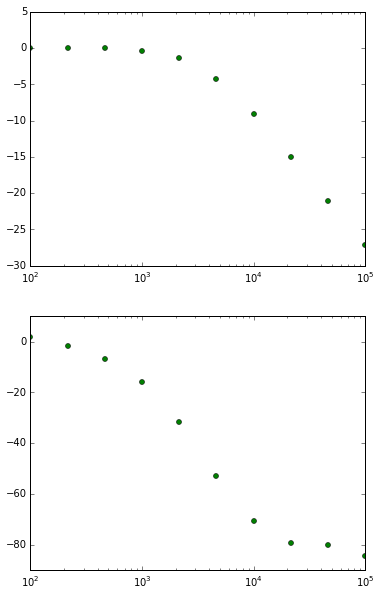

In [75]:
#*********************************************
#grafico
#*********************************************
fig = plt.figure();
fig, ax = plt.subplots(2, sharex=True, figsize=(6, 10))
ax1 = plt.subplot(211);
ax2 = plt.subplot(212);
#DADOS
#*********************************************
#grafico experimental
ax1.semilogx(freq_vecr,t_dbr, 'og', markersize=5, label='dados')
ax2.semilogx(freq_vecr,fase_vecr,'og', markersize=5)

fig; # mostra a figura


Na célula abaixo, definimos funções para calcular a função de transferência complexa para um circuito $RC$, a transmitância e a fase de função de transferência
$$H(\omega,R,C)=\frac{Z_c}{R+Zc}=\frac{-j/(\omega C)}{R-j/(\omega C)};$$ 
a transmitância $$T(\omega,R,C)=|H(\omega,R,C)|^2;$$
e a fase da função de transferência $$\phi(\omega,R,C)=\arg(H(\omega,R,C)).$$

Explicitamos acima a dependência com os parâmetros $R$ e $C$ para lembrá-los que estes parâmetros devem ser considerados no caso de outro circuito, e.g., no $RL$ devemos ter uma função que depende de $R,L$

In [124]:
#*********************************************
#definindo funcao que calcula a curva teorica
#r - resistencia
#c - capacitancia
#*********************************************
def funcH(freq, r, c):
    j=complex(0,1)
    omega=2*np.pi*freq
    #reatancias
    Xc=1/(omega*c)
    #impedancias
    Zc=-j*Xc
    #funcao de transferencia
    H= Zc/(r+Zc)
    return H
def funcT(freq, r, c):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    H = funcH(freq, r, c)
    #transmitancia, linear
    T = np.abs(H)**2
    return T
def funcTdb(freq, r, c):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    H = funcH(freq, r, c)
    #transmitancia, linear
    Tdb = 20*np.log10(np.abs(H))
    return Tdb
def funcPhi(freq, r, c):
    #****************
    #comente estes valores 
    #caso deseje que eles tambem sejam ajustados
    #****************
    #Funcao H
    H = funcH(freq, r, c)
    #fase em graus
    phi = np.angle(H,deg=True)
    return phi

In [128]:
chute_inicial = (150,0.22e-6,) #chute inicial igual parametros nominais
pfit, pcov = curve_fit(funcTdb, freq_vecr, t_dbr, p0=chute_inicial)
#print('Parametros do ajuste (r (Ohms),c (faraday)):', pfit)
#print(popt)
perr = np.sqrt(np.diag(pcov))
print(error)
print("\nParâmetros ajustados segundo a função curve_fit:")
print("pfit = ", pfit)
print("\nErros estimados pela função curve_fit:")
print("perr = ", perr)

[1002851866.3097464, 0.96910884637176609]

Parâmetros ajustados segundo a função curve_fit:
pfit =  [  1.54908472e+02   2.56710281e-07]

Erros estimados pela função curve_fit:
perr =  [ inf  inf]


/Applications/Pineapple.app/Contents/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


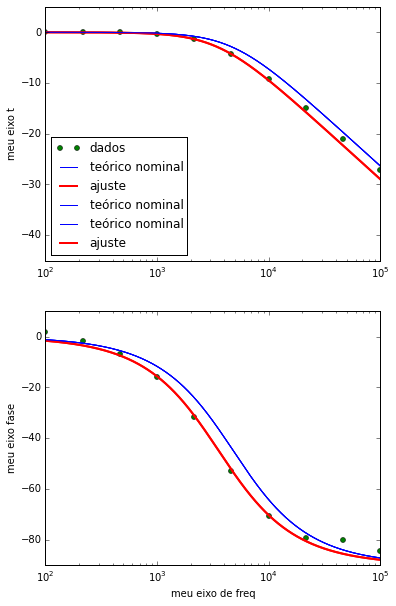

In [130]:
#*********************************************
#vetor de frequencias teorica, com bem mais pontos que o experimental
freq_t=np.logspace(np.log10(freq_vecr[0]),np.log10(freq_vecr[-1]),1000)
#transmicao teorica usando valores nominais, checar se a curva parece com o experimento
T = funcT(freq_t,150,0.22e-6)
fase = funcPhi(freq_t,150,0.22e-6)
#*********************************************
ax1.semilogx(freq_t,10*np.log10(T),'-b',label='teórico nominal') # curva teorica
ax2.semilogx(freq_t,fase,'-b') # curva teorica
fig

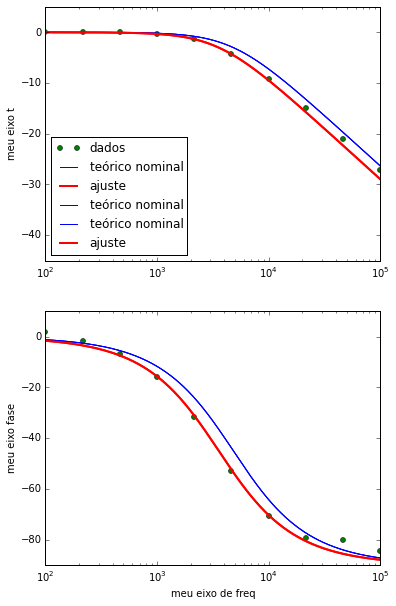

In [117]:
#*********************************************
#graficando o ajuste em vermelho solido 
#calculando os a funcao teorica com os valores obtidos do ajuste
Tfit = funcT(freq_t, *popt)
fasefit = funcPhi(freq_t, *popt)

ax1.semilogx(freq_t,10*np.log10(Tfit),'-r',linewidth=2, label='ajuste')
ax2.semilogx(freq_t,fasefit,'-r',linewidth=2)

#ajustes dos graficos
#ax1.set_xlabel('meu eixo freq')
ax1.set_ylabel('meu eixo t')
ax2.set_xlabel('meu eixo de freq')
ax2.set_ylabel('meu eixo fase')
ax2.set_xlim((100,1e5)) #LIMITES DO EIXO X
#ax2.set_xlim((100,1e5))
ax1.set_ylim((-45,5)) #LIMITES DO EIXO Y
#ax1.legend(loc='lower right')
#plt.title('Diagrama Bode')
fig.tight_layout
plt.subplots_adjust(hspace=0.5)
#plt.subplots_adjust(wspace=0.4)
ax1.legend(loc='lower left')
fig

In [131]:
#salvando
print('pasta atual:',os.getcwd())  
name='bode_rc_dados'
folder_path=os.getcwd()
ext='pdf'
path=os.path.join(folder_path,name + '.' + ext)
fig.savefig(path,format='pdf')
print('arquivo salvo:',path)

pasta atual: /Users/gsw/Dropbox/Disciplinas/f429/2017_1s/python
arquivo salvo: /Users/gsw/Dropbox/Disciplinas/f429/2017_1s/python/bode_rc_dados.pdf
